### DASK sum reduction CPU


In [ ]:
import dask.array as da
import numpy as np

# Create a random Dask array
x = da.random.random((10,), chunks=(5,))

# Compute the sum reduction along axis 0
result = da.sum(x, axis=0)

# Execute the computation and get the final result
final_result = result.compute()
final_result

In [ ]:
print(x)
print('\n')
print(x.compute())
print('\n')
x

dask.array<random_sample, shape=(10,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>


[0.62499682 0.29429587 0.61964359 0.03448744 0.62678015 0.95747788
 0.98833278 0.64426268 0.84442353 0.02444192]




dask.array<random_sample, shape=(10,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

### DASK sum reduction GPU

In [ ]:
!python -m pip install dask-cuda

In [ ]:
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster() # не работает без GPU
client = Client(cluster)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37085
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34487'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44369', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44369
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:39058
INFO:distributed.scheduler:Receive client connection: Client-82eaba01-8d44-11ee-b9b8-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:39074


In [ ]:
import cupy as cp

x = x.map_blocks(cp.asarray)

result = x.sum().compute() # используется ли GPU???

print(result)

### Исследование зависимости времени выполнения от размера данных - CPU vs GPU


In [ ]:
SIZE_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5e6, 10e6, 50e6]

### CPU ###
SIZE = 50000000
x = da.random.random((SIZE,), chunks=(int(SIZE/5),)) # везде разбиваем по 5 частей. Как можно поисследовать???

In [ ]:
%%timeit

x.sum().compute()

435 ms ± 8.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
### GPU ### - считаются разные массивы одинаковых размеров. Как отследить compute делается на cpu или на gpu???
SIZE = 50000000
x = da.random.random((SIZE,), chunks=(int(SIZE/5),))
x = x.map_blocks(cp.asarray)

In [ ]:
%%timeit

with cp.cuda.Device(0):
  x.sum().compute()

cp.cuda.Device(0).synchronize()

572 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from cupyx.profiler import benchmark

def dask_reduction_sum(a):
  return a.sum().compute()

print("GPU performance:\n")
for SIZE in SIZE_list:
  x = da.random.random((SIZE,), chunks=(int(SIZE/5),))
  x = x.map_blocks(cp.asarray)
  print(benchmark(dask_reduction_sum, (x,), n_repeat=20, n_warmup=2))
  print("\n")


dask_reduction_sum  :    CPU:236844.859 us   +/-275689.723 (min: 9027.350 / max:585221.314) us     GPU-0:236874.312 us   +/-275700.086 (min: 9047.744 / max:585263.123) us




In [ ]:
T_cpu = [6.76, 7.7, 7.59, 6.57, 6.93, 6.76, 6.73, 7.59, 9.49, 10.7, 18.5, 46.7, 219, 435] # ms
T_gpu_timeit = [12.6, 46.7, 31.2, 21, 35.3, 36.3, 23, 34.4, 48.2, 48.5, 66.1, 94.3, 74.1, 572] # ms
T_gpu_benchmark = [40.87, 40.39, 45.12, 34.997, 35.91, 38.85, 15.18, 15.38, 17.84, 21.77, 11.31, 49.3, 109.836, 236.874] # ms


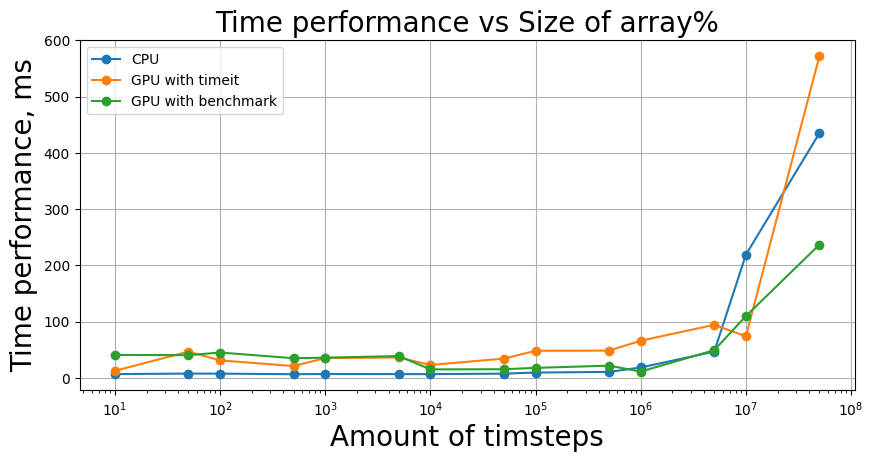

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('Amount of timsteps', fontsize = 20)
ax.set_ylabel('Time performance, ms', fontsize = 20)
plt.title('Time performance vs Size of array%', fontsize = 20)
ax.grid(True)
plt.semilogx(SIZE_list, T_cpu, marker = 'o', label='CPU')
plt.semilogx(SIZE_list, T_gpu_timeit, marker = 'o', label='GPU with timeit')
plt.semilogx(SIZE_list, T_gpu_benchmark, marker = 'o', label='GPU with benchmark')
plt.legend()
# plt.savefig('CPU_vs_GPU')